In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import pytorch_lightning as pl
from itertools import product
import torch.nn.functional as F
import pandas as pd

sys.path.append(os.path.join(os.getcwd(), '../symlie'))
sys.path.append(os.path.join(os.getcwd(), '../sympdee/sympde/misc'))

from run import parse_options, main, process_args, generate_data
from generate_data import save_splits

from data.generate_flat import create_flat, plot_flat
from data.generate_flower import create_flower, plot_flower
from data.transforms import Transform
from model.networks.linear import CalculatedP

from tb_analysis import get_data, get_results

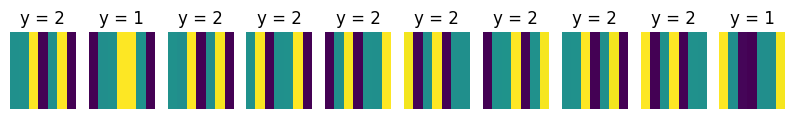

(10, 1, 7)


In [2]:
args = parse_options(notebook=True)
args = process_args(args)

out = create_flower(N=10, **args.data_kwargs, **args.transform_kwargs)
x, y, centers = out['x'], out['y'], out['centers']

try:
    x = x.reshape(-1, args.space_length, args.space_length)
except:
    x = x.reshape(-1, 1, args.space_length)
plot_flower(x=x, y=y)

print(x.shape)

In [3]:
args = parse_options(notebook=True)
args.data_dir = '../data/sinev2'
args = process_args(args)
generate_data(args)

Creating 10000 for train.
Creating 1000 for val.
Creating 1000 for test.


In [ ]:
args = parse_options(notebook=True)

args.net = 'Predict-NoneP'
args.data_dir = '../data/sinev2'

args.do_return = False
args.persistent_workers = True
args.num_workers = 7

args.max_epochs = 10

args.train = True
args.test = False
args.version = 'dev'
args.predict = True

args.n_splits = [400, 1000, 1000]

args = process_args(args)

model, trainer, datamodule, preds = main(args)


In [ ]:
y_trues = torch.load(os.path.join(trainer.logger.log_dir, 'y_trues.pt'))
y_preds = torch.load(os.path.join(trainer.logger.log_dir, 'y_preds.pt'))
y_trues.shape, y_preds.shape

In [ ]:
mse_loss = F.mse_loss(y_preds, y_trues)
print(mse_loss.item())

l = 4
plt.plot(y_trues, y_preds, 'o', alpha = 0.1)
plt.plot([0, l], [0,l], 'k--')
plt.show()

# Run_twice

Seed set to 1




###	Version:  version_0 	###
###	Name:  symlieflat_datasinev2_netTrainP_lr-1.00_seed1 	###


Loaded model from ../logs_symlie/symlieflat_datasinev2_netTrainP_lr-1.00_seed1/version_0/checkpoints
Predicting...


/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Predicting DataLoader 0: 100%|██████████| 500/500 [00:01<00:00, 482.18it/s]


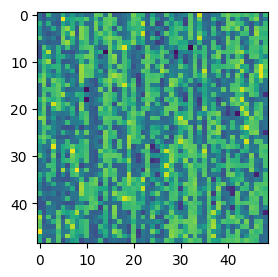

In [3]:
# lrs = torch.logspace(-7, -1, 7)
lrs = [1e-2]

seeds = torch.arange(1,2)

P_preds = {}
for seed, lr in product(seeds, lrs):

    args = parse_options(notebook=True)
    args.net = 'TrainP'

    args.data_dir = '../data/sinev2'

    args.train = False
    args.do_return = False

    args.test = False
    args.predict = True
    args.version = 'version_0'

    args.max_epochs = 5
    # args.batch_size = 64

    args.lr = lr
    args.seed = seed

    args = process_args(args)
    model, trainer, datamodule, _ = main(args)

    # Visualize and save the predicted P matrix
    P_pred = model.net.P.data.clone()
    P_pred = model.net.normalize_P(P_pred)

    P_preds[seed.item()] = P_pred

    plt.figure(figsize = (3,3))
    plt.imshow(P_pred)
    plt.show()

In [ ]:
x, y, eps, centers = batch = next(iter(datamodule.test_dataloader()))

In [ ]:
out_a, out_b = model(batch)

loss_fn = nn.MSELoss()
loss_fn(out_a, out_b)

In [ ]:
out_a, out_b = model(batch)
print('Output NOT allclose!' if not torch.allclose(out_a, out_b) else 'pass')
out_a, out_b

In [ ]:
nets = ['Predict-NoneP', 'Predict-CalculatedP', 'Predict-TrainedP']

for seed, net in product(seeds, nets):
    args = parse_options(notebook=True)

    args.net = net
    args.seed = seed

    args.data_dir = '../data/sinev2'
    
    args.max_epochs = 5
    args.n_splits = [400, 1000, 1000]

    if net == 'Predict-TrainedP':
        args.P_pred = P_preds[seed.item()]

    args = process_args(args)
    model, trainer, datamodule, _ = main(args)


In [ ]:
data = get_data(filter = 'symlieflat', logdir = '../logs_symlie')
data = get_results(data, metrics = ['test_loss'])

In [ ]:
df = pd.DataFrame()

for k, v in data.items():
    _, _, net, _, seed, _, _ = k.split('_')
    net = net.split('-')[-1]
    seed = int(seed.replace('seed', ''))

    test_loss = v['test_loss']
    if len(test_loss) == 0:
        print(net, seed)
        test_loss = [np.nan]
    assert len(set(test_loss)) == 1, test_loss
    test_loss = test_loss[0]

    df.at[seed, net] = test_loss
df

In [ ]:
df = df[['NoneP', 'CalculatedP', 'TrainedP']]

In [ ]:
fig, axs = plt.subplot_mosaic("AAA;BCD", figsize = (8,6), tight_layout = True, gridspec_kw = dict(height_ratios = [0.5, 1]))

ax = axs['A']

for i, (seed, vals) in enumerate(df.iterrows()):
    ax.plot(vals, label = seed, marker = None, ls = '--', alpha = 0.1, color = 'k')

net_colors = {'NoneP': 'C0', 'CalculatedP': 'C1', 'TrainedP': 'C2'}

for i, (net, test_losses) in enumerate(df.T.iterrows()):
    vals = test_losses.values
    ax.scatter(np.full_like(vals, i), vals, alpha = 0.5, marker = 'x', color = net_colors[net])

ax.set_xticks(np.arange(len(df.T)), df.T.index)
ax.set_ylabel('Test loss')

calculated_Ps = {k: v() for k, v in CalculatedP(size=7).transform_funcs.items()}

P_none = calculated_Ps['none']
P_calculated = calculated_Ps['space_translation']
P_pred = P_preds[1]

P_plots = [P_none, P_calculated, P_pred]

for i, (P, ax_i) in enumerate(zip(P_plots, ['B', 'C', 'D'])):
    ax = axs[ax_i]
    ax.imshow(P)
    # ax.set_axis_off()
    ax.patch.set_edgecolor(list(net_colors.values())[i])

    ax.patch.set_linewidth(5)  

    # Disable ticks
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [ ]:
P_preds_tensor = torch.stack(list(P_preds.values()))

plt.hist( P_preds_tensor.numpy().flatten(), bins = 100, alpha = 0.5, label = 'Trained P')
plt.show()

In [ ]:
torch.std(P_preds_tensor, dim = 0)

In [ ]:
plt.figure(figsize = (3,3))
plt.imshow( torch.std(P_preds_tensor, dim = 0) )
plt.colorbar()
plt.show()


plt.figure(figsize = (3,3))
plt.imshow( torch.mean(P_preds_tensor, dim = 0) )
plt.colorbar()
plt.show()